### Classification based on point cloud features

In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
#%matplotlib inline
%pylab inline
import os
import sys
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1

In [3]:
def get_scores(X_train, X_valid, y_train, param, num_round):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_valid)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)
    score = bst.predict(dval, output_margin=True, ntree_limit=bst.best_ntree_limit)
    score = np.around(score, 3)
    
    return score

In [4]:
from sklearn import metrics
def buildROC(target_test,test_preds, num_round):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    #plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label=str(num_round))#, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return roc_auc

In [5]:
paired_structures = ['5N', '6N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

In [8]:
stack = 'MD594'
feature_dir = os.environ['ROOT_DIR'] + 'CSHL_patches_features/'+stack+'/'
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patches_features/MD589/'


In [7]:
!mkdir figures
fn = 'figures/'

mkdir: cannot create directory ‘figures’: File exists


5N 480 479 0.8018769551616267
['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/5N/MD594_5N_positive.pkl', '/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/5N/MD594_5N_negative.pkl']
6N 269 216 0.7711340206185567
['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/6N/MD594_6N_positive.pkl', '/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/6N/MD594_6N_negative.pkl']
7n 1000 1000 0.89
['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/7n/MD594_7n_positive.pkl', '/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/7n/MD594_7n_negative.pkl']
Amb 120 120 0.8625
['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/Amb/MD594_Amb_positive.pkl', '/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/Amb/MD594_Amb_negative.pkl']
LC 240 240 0.7833333333333333
['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/LC/MD594_LC_positive.pkl', '/data/BstemAtlasD

/data/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


VCP 450 416 0.8210161662817552
['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/VCP/MD594_VCP_positive.pkl', '/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/VCP/MD594_VCP_negative.pkl']
DC 850 811 0.7892835641180012
['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/DC/MD594_DC_positive.pkl', '/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/DC/MD594_DC_negative.pkl']
AP 190 190 0.8736842105263158
['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/AP/MD594_AP_positive.pkl', '/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/AP/MD594_AP_negative.pkl']
12N 390 390 0.8653846153846154
['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/12N/MD594_12N_positive.pkl', '/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/12N/MD594_12N_negative.pkl']
RtTg 800 800 0.71875
['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_patches_features/MD594/RtTg/MD594_RtTg_positive.

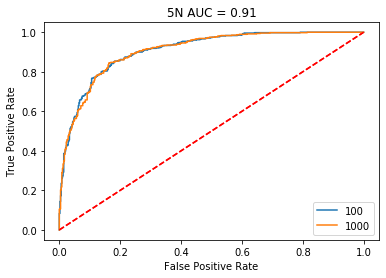

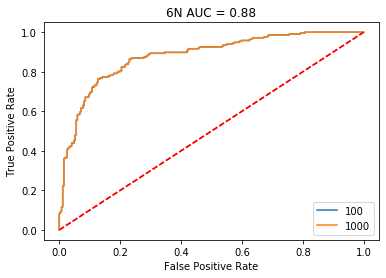

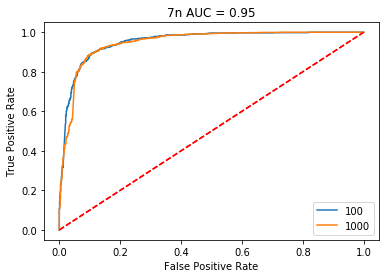

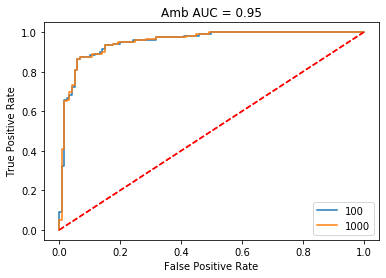

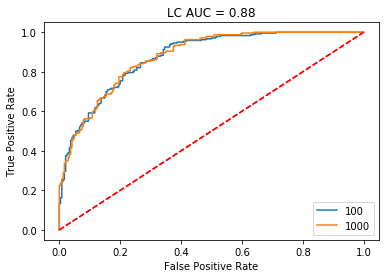

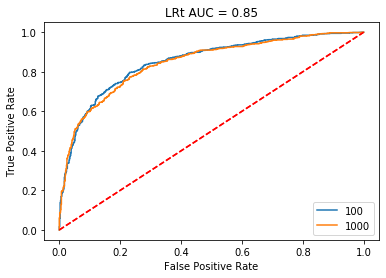

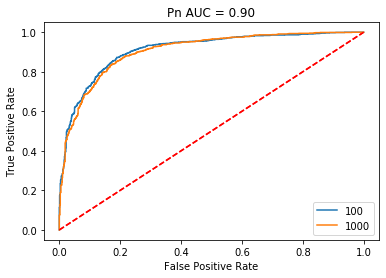

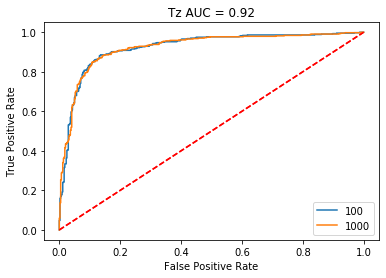

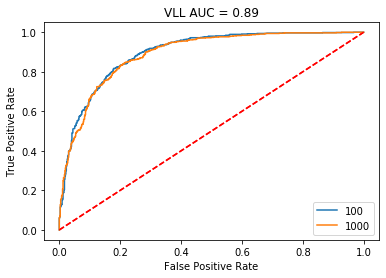

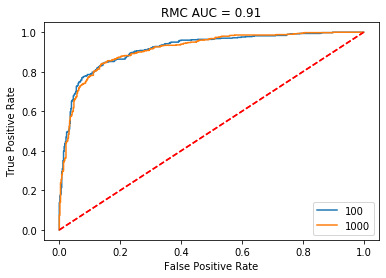

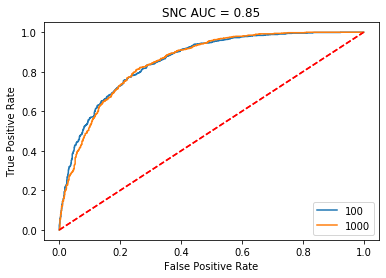

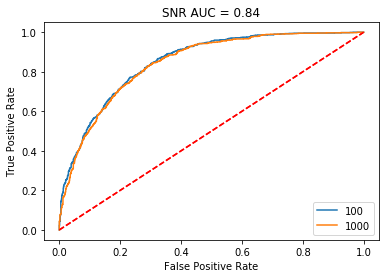

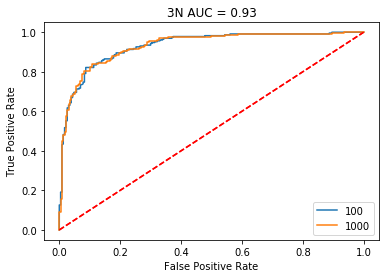

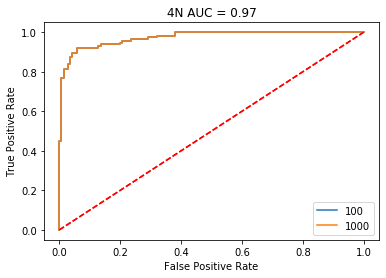

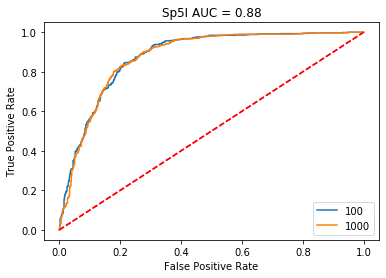

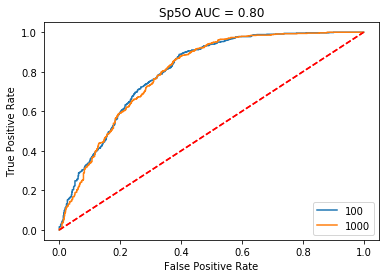

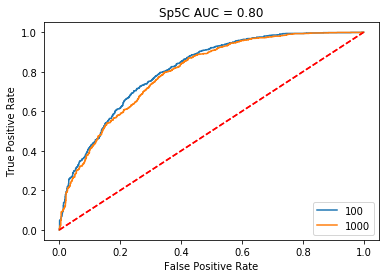

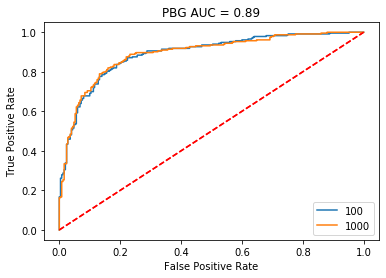

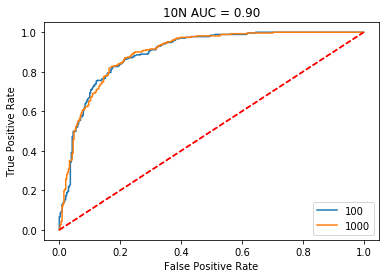

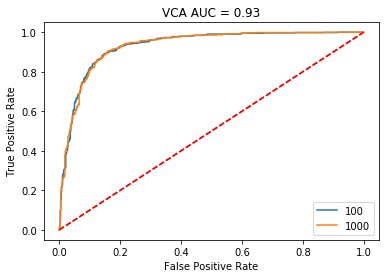

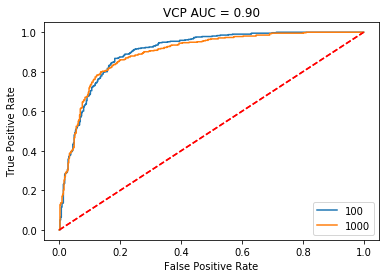

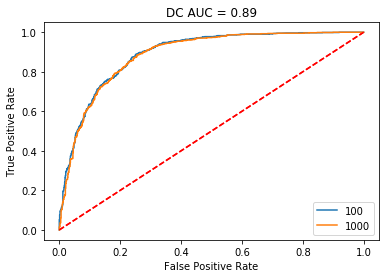

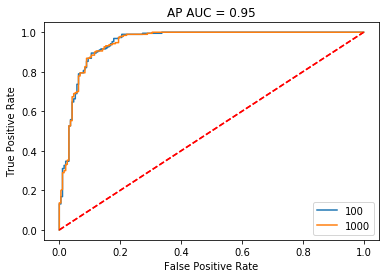

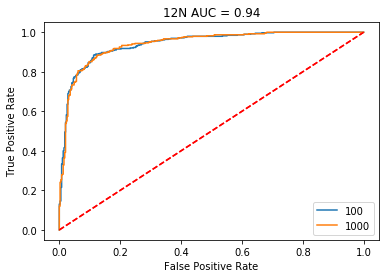

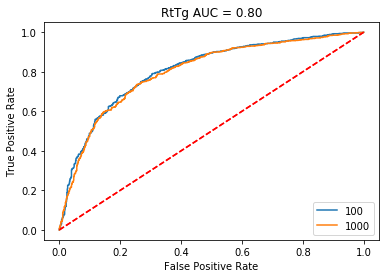

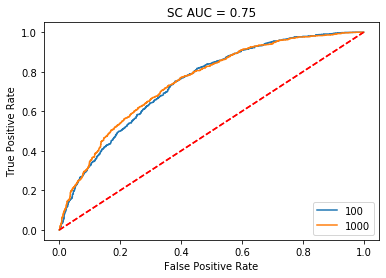

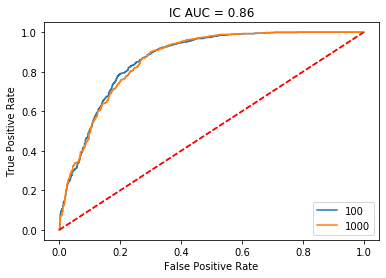

In [9]:
acc_all=[]
num_round=np.array([100,1000])
auc_all = np.zeros((len(num_round), len(all_structures)))
#plt.figure(figsize=[15,50])
for structure in all_structures:
    seq = np.where(np.array(all_structures)==structure)[0]
    #plt.subplot(10,3,seq+1)
    plt.figure()
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    fp =[]
    fp.append(feature_dir+structure+'/'+stack+'_'+structure+'_positive.pkl') 
    fp.append(feature_dir+structure+'/'+stack+'_'+structure+'_negative.pkl')
    X_valid = []
    y_valid = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_valid.extend(np.array(clouds))
        y_valid.extend([1-state]*len(clouds))
    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)
    
    for i in range(len(num_round)):
        y_pred_valid = get_scores(X_train, X_valid, y_train, param, num_round[i])
        pred = y_pred_valid>0
        acc = sum(pred ==y_valid)/len(y_valid)
        auc = buildROC(y_valid, y_pred_valid, num_round[i])
        auc_all[i,seq] = auc
    plt.title(structure+' AUC = %0.2f'%auc)
    acc_all.append(acc)
    print(structure, len(y_valid)-sum(y_valid), sum(y_valid), acc)
    print(fp)
    #plt.savefig(fn+stack+'_'+structure+'_ROC.jpg')

Text(0.5, 1.0, 'MD594  AUC = [0.888 0.886]')

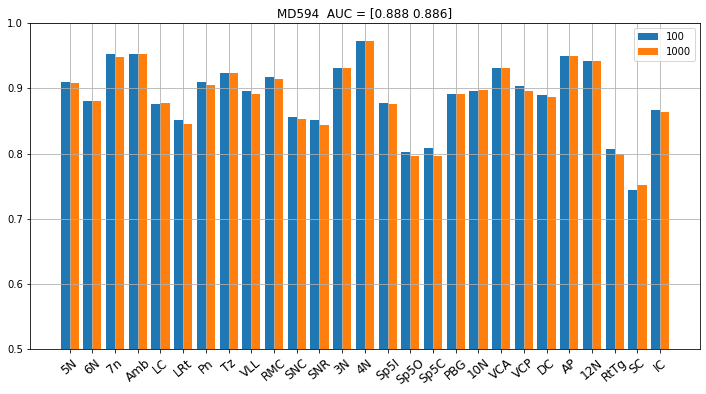

In [10]:
figure(figsize=(12,6))
index = np.arange(auc_all.shape[1])
width = 0.4
for i in range(len(num_round)):
    plt.bar(index+i*width, auc_all[i,:], width, label=str(num_round[i]))
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title(stack+'  AUC = '+str(np.round(np.mean(auc_all,1),3)))
#plt.savefig(fn+stack+'_AUC_200um.jpg')

5N 440 440 0.8674242424242424
6N 50 43 0.9285714285714286
7n 1000 1000 0.9266666666666666
Amb 130 130 0.9102564102564102
LC 240 240 0.8819444444444444
LRt 760 760 0.8289473684210527
Pn 1000 992 0.8929765886287625
Tz 500 500 0.8666666666666667
VLL 690 690 0.8526570048309179
RMC 570 570 0.8508771929824561
SNC 830 785 0.8639175257731959
SNR 999 1000 0.81
3N 240 240 0.9166666666666666
4N 120 45 0.94
Sp5I 730 730 0.8356164383561644
Sp5O 680 662 0.7841191066997518
Sp5C 1000 1000 0.7616666666666667
PBG 260 216 0.9440559440559441
10N 460 405 0.9038461538461539
VCA 660 647 0.9033078880407125
VCP 489 475 0.8827586206896552
DC 996 1000 0.8597662771285476
AP 150 145 0.9438202247191011
12N 389 390 0.8675213675213675
RtTg 150 150 0.7666666666666667
SC 1000 1000 0.7216666666666667
IC 999 1000 0.85


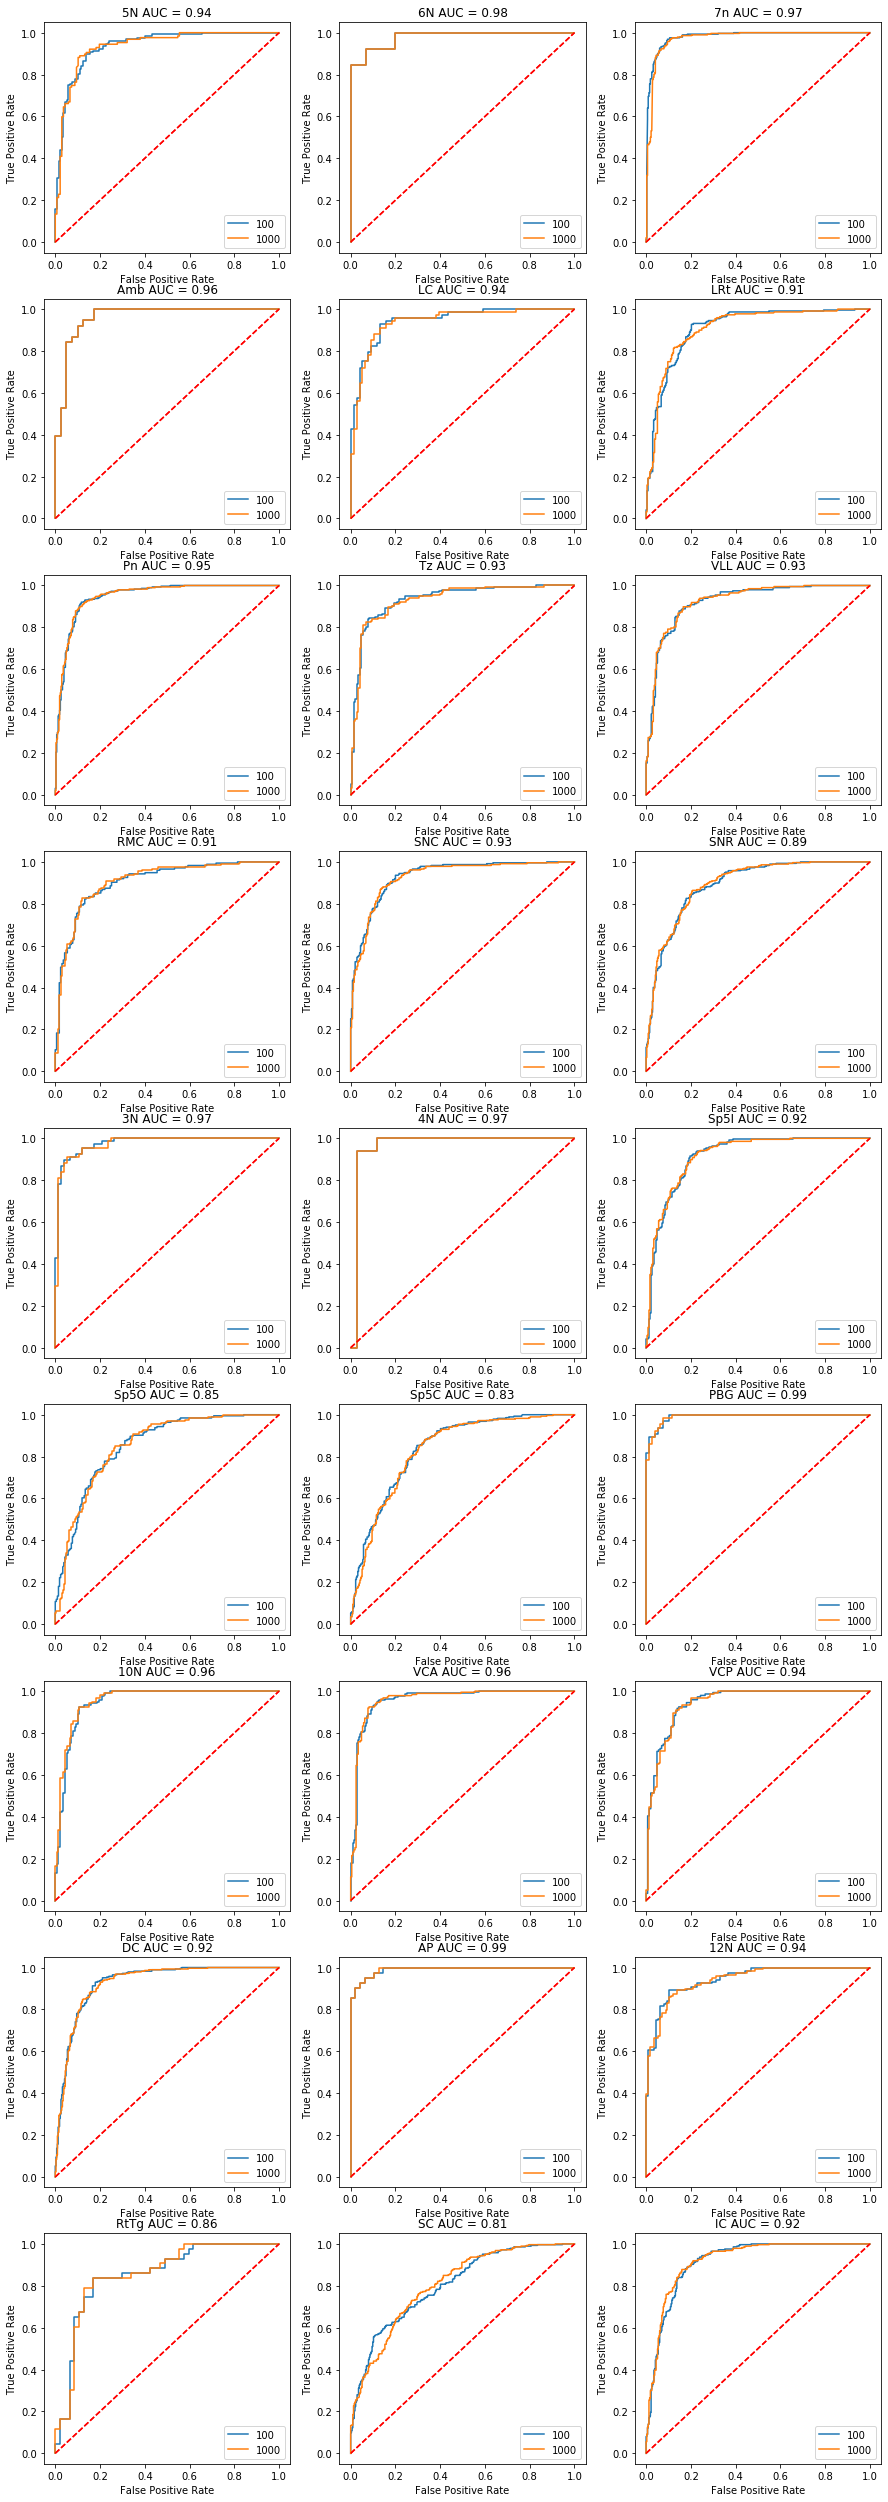

In [11]:
acc_all=[]
num_round=np.array([100,1000])
auc_all = np.zeros((len(num_round), len(all_structures)))
plt.figure(figsize=[15,50])
for structure in all_structures:
    seq = np.where(np.array(all_structures)==structure)[0]
    plt.subplot(10,3,seq+1)
    fp =[dir for dir in glob(cell_dir+structure+'/*')]
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        features.extend(np.array(clouds))
        labels.extend([1-state]*len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.30, random_state=6)
    for i in range(len(num_round)):
        y_pred_valid = get_scores(X_train, X_valid, y_train, param, num_round[i])
        pred = y_pred_valid>0
        acc = sum(pred ==y_valid)/len(y_valid)
        auc = buildROC(y_valid, y_pred_valid, num_round[i])
        auc_all[i,seq] = auc
    plt.title(structure+' AUC = %0.2f'%auc)
    acc_all.append(acc)
    print(structure, len(labels)-sum(labels), sum(labels), acc)
#plt.savefig(fn+stack+'_ROC_200um.jpg')

Text(0.5, 1.0, 'MD594  AUC = [0.929 0.928]')

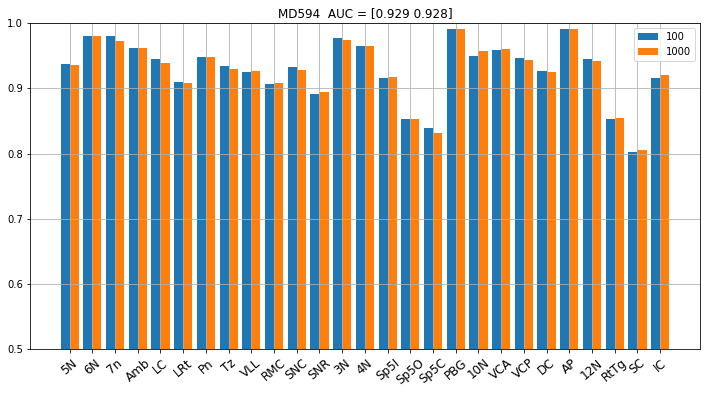

In [12]:
figure(figsize=(12,6))
index = np.arange(auc_all.shape[1])
width = 0.4
for i in range(len(num_round)):
    plt.bar(index+i*width, auc_all[i,:], width, label=str(num_round[i]))
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title(stack+'  AUC = '+str(np.round(np.mean(auc_all,1),3)))

In [30]:
!aws s3 ls s3://mousebrainatlas-data/CSHL_data_processed/MD585/

                           PRE MD585_custom_transforms/
                           PRE MD585_elastix_output/
                           PRE MD585_masks/
                           PRE MD585_masks_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141/
                           PRE MD585_masks_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped/
                           PRE MD585_prep1_thumbnail/
                           PRE MD585_prep1_thumbnail_mask/
                           PRE MD585_prep2_down8_grayJpeg/
                           PRE MD585_prep2_lossless/
                           PRE MD585_prep2_lossless_gray/
                           PRE MD585_prep2_lossless_jpeg/
                           PRE MD585_prep2_thumbnail/
                           PRE MD585_prep3_lossless/
                           PRE MD585_prep3_lossless_jpeg/
                           PRE MD585_prep3_thumbnail/
                           PRE MD585_prep5_thumbnail/
                           PRE 

In [7]:
origin= ['area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width', 'density']
columns = []
for i in range(10):
    name = 'DMVec'+str(i)
    for j in range(10):
        columns.append(name+'*'+str(np.around(0.1*(j+1),2)))
for i in range(10):
    name = origin[i]
    for j in range(10):
        columns.append(name+'*'+str(np.around(0.1*(j+1),2)))
columns.append(origin[-1])

In [8]:
sets = columns
! mkdir FeatureMap

mkdir: FeatureMap: File exists


LC 479 0.875


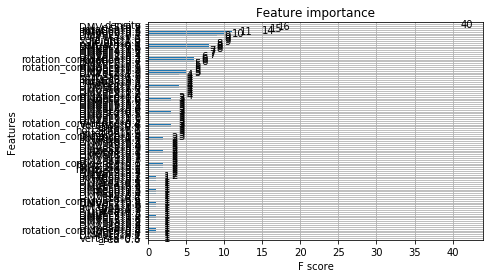

In [13]:
structure = 'LC'
fp =[dir for dir in glob(cell_dir+structure+'/*')]
features = []
labels = []
for state in range(2):
    clouds = pickle.load(open(fp[state],'rb'))
    features.extend(np.array(clouds))
    labels.extend([state]*len(clouds))
features = np.array(features)
labels = np.array(labels)
data = pd.DataFrame(features,columns=sets)
label = pd.DataFrame(labels)
X_train, X_valid, y_train, y_valid = train_test_split(data, label, test_size=0.30, random_state=6)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_valid)
num_round = 100
bst = xgb.train(param, dtrain, num_round, verbose_eval=False)
score = bst.predict(dval, output_margin=True, ntree_limit=bst.best_ntree_limit)
y_pred_valid = np.around(score, 3)
pred = y_pred_valid>0
acc = sum(pred.reshape(-1,1) == np.array(y_valid))/len(y_valid)
print(structure, features.shape[0], acc)
xgb.plot_importance(bst)
# plt.savefig('FeatureMap/'+structure+'.jpg')
# fig = plt.figure(figsize=(18,18))
# iax = fig.add_subplot(111)
# xgb.plot_tree(bst,ax=iax)
# plt.savefig('FeatureMap/'+structure+'_tree.jpg')

In [13]:
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_new_regions_features/MD589/'

In [14]:
for structure in all_structures:
    #structure = '12N'
    fp =[dir for dir in glob(cell_dir+structure+'/*')]
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        features.extend(np.array(clouds))
        labels.extend([state]*len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.30, random_state=6)
    y_pred_valid = get_scores(X_train, X_valid, y_train, param)
    pred = y_pred_valid>0
    #pred = get_predictions(y_pred_valid)
    acc = sum(pred ==y_valid)/len(y_valid)
    print(structure, features.shape[0], acc)

5N 88 1.0
6N 10 0.3333333333333333
7N 178 1.0
7n 252 0.9868421052631579
Amb 26 0.875
LC 48 0.9333333333333333
LRt 152 0.9782608695652174
Pn 202 0.9836065573770492
Tz 100 0.9666666666666667
VLL 138 1.0
RMC 114 0.8857142857142857
SNC 166 1.0
SNR 252 0.9736842105263158
3N 48 0.9333333333333333
4N 24 1.0
Sp5I 146 0.9545454545454546
Sp5O 136 0.975609756097561
Sp5C 282 1.0
PBG 52 0.8125
10N 92 0.9285714285714286
VCA 132 1.0
VCP 98 0.9666666666666667
DC 222 0.9402985074626866
AP 30 0.7777777777777778
12N 78 1.0
RtTg 30 0.7777777777777778
SC 364 1.0
IC 382 0.991304347826087
